In [1]:
%matplotlib inline

import os
import h5py
import tqdm
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc

import tensorflow as tf
from tensorflow import keras

print("TF  Version",tf.__version__)

TF  Version 2.4.0


In [2]:
# check and set path before loading modules
print(os.getcwd())
DIR = "/tf/notebooks/brdd/xAI_stroke_3d/"
if os.getcwd() != DIR:
    os.chdir(DIR)
    
import functions_model_definition as md
import functions_metrics as fm
import functions_read_data as rdat
import functions_gradcam as gc
import functions_plot_heatmap as fph

/tf


## Load Data

In [3]:
# Define the path + output path:
DATA_DIR = DIR + "data/"

version = "10Fold_sigmoid_V0" # one of:
# 10Fold_sigmoid_V0, 10Fold_sigmoid_V1, 10Fold_sigmoid_V2, 10Fold_sigmoid_V2f, 10Fold_sigmoid_V3
# 10Fold_softmax_V0, 10Fold_softmax_V1, andrea
save_plot = False

# Define Model Version
model_version = 1

# define paths
WEIGHT_DIR, OUTPUT_DIR, pic_save_name = rdat.dir_setup(DIR, version)

In [4]:
## load images and ids
(X_in, pat, id_tab, all_results, num_models) = rdat.version_setup(
    DATA_DIR = DATA_DIR, version = version, model_version = model_version)

## load patient data
PAT_CSV_DIR = "/tf/notebooks/hezo/stroke_zurich/data/baseline_data_zurich_prepared0.csv" 
pat_dat = pd.read_csv(PAT_CSV_DIR, sep=";")
pat_dat

,p_id,mrs3,age,sexm,nihss_baseline,mrs_before,stroke_beforey,tia_beforey,ich_beforey,rf_hypertoniay,rf_diabetesy,rf_hypercholesterolemiay,rf_smokery,rf_atrial_fibrillationy,rf_chdy,eventtia,iaty,ivty
0,101,1,"85,6",0,9.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,NaN,NaN
1,102,1,"66,7",1,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,NaN,NaN
2,103,0,"29,2",0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN
3,104,0,83,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0,NaN,NaN
4,105,6,"89,2",0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,540,2,80,0,7.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,0.0,0
514,541,0,19,1,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0,1
515,542,1,68,1,3.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1,0.0,0
516,543,4,74,0,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0,0


## Model

In [5]:
# define model
(input_dim, output_dim, LOSS, layer_connection, last_activation) = md.model_setup(version)

model_3d = md.stroke_binary_3d(input_dim = input_dim,
                               output_dim = output_dim,
                               layer_connection = layer_connection,
                               last_activation = last_activation)

model_3d.compile(
    loss=LOSS,
    optimizer=keras.optimizers.Adam(learning_rate=5*1e-5),
    metrics=["acc", tf.keras.metrics.AUC()]
)

# define if print should be enabled
check_print = True


In [6]:
# Define Model Name
generate_model_name = md.set_generate_model_name(
    model_version = model_version, 
    layer_connection = layer_connection, 
    last_activation = last_activation, 
    path = WEIGHT_DIR)                                                 


In [7]:
vis_layers = [i.name for i in model_3d.layers[1:-6]]
vis_layers = [vis_layer for vis_layer in vis_layers if vis_layer.startswith("conv")]

# Oclusion Functions

In [8]:
def iter_occlusion(volume, size=4, stride = None):
  # volume: np array in shape 128, 128, 64, 1

  occlusion_center = np.full((size[0], size[1], size[2], 1), [0.5], np.float32)

  for x in range(0, volume.shape[0]-size[0]+1, stride):
    for y in range(0, volume.shape[1]-size[1]+1, stride):
      for z in range(0, volume.shape[2]-size[2]+1, stride):
        tmp = volume.copy()

        tmp[x:x + size[0], y:y + size[1], z:z + size[2]] = occlusion_center

        yield x, y, z, tmp
  
def volume_occlusion(volume, correct_class, occlusion_size, 
                     model = model_3d,
                     occlusion_stride = None):

  # print('occluding...')
  
  volume = volume.reshape(128,128,28,1)
  
  if len(occlusion_size) == 1:
    occlusion_size = np.array([occlusion_size, occlusion_size, occlusion_size])
  elif len(occlusion_size) != 3:
    raise ValueError('occluson_size must be a scalar or a 3 element array')

  if occlusion_stride is None:
    occlusion_stride = np.min(occlusion_size)
  elif any(occlusion_stride > occlusion_size):
    raise ValueError('stride must be smaller or equal size')
  
  if any(occlusion_stride == occlusion_size):
    if (not (volume.shape[0] / occlusion_size)[0].is_integer() or
        not (volume.shape[1] / occlusion_size)[1].is_integer() or 
        not (volume.shape[2] / occlusion_size)[2].is_integer()):
      
      raise ValueError('size does not work with this volume')
  elif any(occlusion_stride != occlusion_size):
    if (((volume.shape[0]-occlusion_size[0]) % occlusion_stride) != 0 or 
        ((volume.shape[1]-occlusion_size[1]) % occlusion_stride) != 0 or
        ((volume.shape[2]-occlusion_size[2]) % occlusion_stride) != 0):
      
      raise ValueError('shape and size do not match')

  # num_occlusion =  int(np.prod(((np.array(volume.shape[0:3]) - occlusion_size) / occlusion_stride) + 1))

  heatmap_prob_sum = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), np.float32)
  heatmap_occ_n = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), np.float32)

  # for n, (x, y, z, vol_float) in tqdm.tqdm(enumerate(iter_occlusion(volume, size = occlusion_size, stride = occlusion_stride))):
  #     X = vol_float.reshape(1, volume.shape[0], volume.shape[1], volume.shape[2], 1)
  #     out = model.predict(X)

  #     heatmap_prob_sum[x:x + occlusion_size[0], y:y + occlusion_size[1], z:z + occlusion_size[2]] += out[0]
  #     heatmap_occ_n[x:x + occlusion_size[0], y:y + occlusion_size[1], z:z + occlusion_size[2]] += 1

  ## Faster Implementation
  
  X = []
  xyz = []
  for n, (x, y, z, vol_float) in tqdm.tqdm(enumerate(iter_occlusion(volume, size = occlusion_size, stride = occlusion_stride))):
        X.append(vol_float.reshape(volume.shape[0], volume.shape[1], volume.shape[2], 1))
        xyz.append((x,y,z))
  
  X = np.array(X)
  out = model.predict(X)
  
  for i in range(len(xyz)):
    x,y,z = xyz[i]
    heatmap_prob_sum[x:x + occlusion_size[0], y:y + occlusion_size[1], z:z + occlusion_size[2]] += out[i,0]
    heatmap_occ_n[x:x + occlusion_size[0], y:y + occlusion_size[1], z:z + occlusion_size[2]] += 1
  

  # print("\n")
  # print("calculating heatmap...")

  heatmap = heatmap_prob_sum/heatmap_occ_n
  
  # print("\n done")

  return heatmap#, class_pixels



In [9]:
(res_table, res_images, res_model_names) = gc.get_img_and_models(
        [1], results = all_results, pats = pat, imgs = X_in, 
        gen_model_name = generate_model_name,
        num_models = num_models)

In [10]:
### occlusion
occ_size = (16, 16, 12)
occ_stride = 8
# occ_size = (14, 14, 10)
# occ_stride = 6
print("number of occlusions: ", int(np.prod(((np.array(res_images.shape[1:4]) - occ_size) / occ_stride) + 1)))
print("number of occlusions per axis: ", ((np.array(res_images.shape[1:4]) - occ_size) / occ_stride) + 1)
print((np.asarray(res_images.shape[1:4]) - occ_size) % occ_stride) # all must be zero
print(all(np.array(occ_size) > occ_stride)) # must be true
print(np.array(res_images.shape[1:4]) / occ_size) # if all same, then same ratio of occ_size to image size



number of occlusions:  675
number of occlusions per axis:  [15. 15.  3.]
[0 0 0]
True
[8.         8.         2.33333333]


In [11]:
cnn = model_3d
cnn.load_weights(res_model_names[0][0])
res_table["y_pred_class"][0]

0

In [12]:
import time

start = time.time()
(heatmap) =  volume_occlusion(
    volume = res_images, 
    correct_class = res_table["y_pred_class"][0], 
    occlusion_size = np.array(occ_size), 
    model = cnn,
    occlusion_stride = occ_stride)

end = time.time()
print(end - start)

675it [00:00, 1640.39it/s]


20.536024808883667


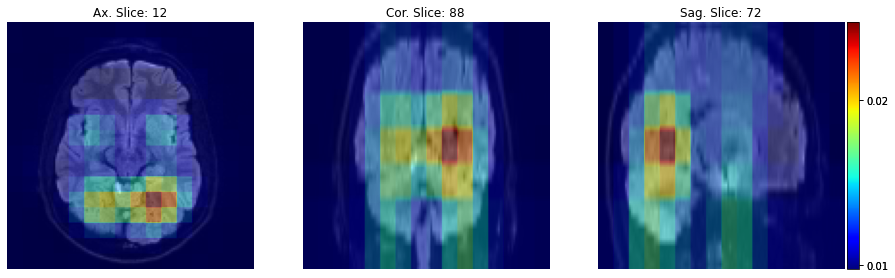

In [13]:
res_images = res_images.reshape(128,128,28)
heatmap = heatmap.reshape(128, 128, 28)

phm.plot_gradcam(res_images, heatmap,
                version = "overlay",
                mode = "def",
                slices = (88,72,12),
                hm_colormap="jet",
                hm_positive=True,
                colorbar=True)

# Occlusion Slider

In [14]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, HBox, VBox, Layout, AppLayout
from IPython.display import display
from termcolor import colored
import ipywidgets as widgets

from importlib import reload
reload(phm)
reload(gc)

def occlusion_interactive_plot(p_id, occ_size, occ_stride, 
                               pred_hm_only=True, cnn = model_3d):
    p_ids = [p_id]
    (res_table, res_images, res_model_names) = gc.get_img_and_models(
        p_ids, results = all_results, pats = pat, imgs = X_in, 
        gen_model_name = generate_model_name,
        num_models = num_models)
    
    print("patient id: ", res_table.p_id[0])
    print("age: ", pat_dat[pat_dat["p_id"] == res_table.p_id[0]]["age"].values[0])
    print("true mrs: ", res_table.mrs[0])
    print("true class: ", res_table.unfavorable[0])
    print(colored("pred class: "+str(res_table.y_pred_class[0]), 
                'green' if res_table["pred_correct"][0] == True else 'red'))
    print("pred prob (class 1): ", res_table.y_pred_trafo_avg[0])
    print("pred uncertainty: ", res_table.y_pred_unc[0])
    # print("heatmap unc. last layer: ", res_table.y_pred_unc[0])
    
    ## Generate heatmap
    if pred_hm_only:
        invert_hm = "all" if res_table.y_pred_class[0] == 0 else "none"
        gcpp_hm = "last"
        cmap = "jet"
        hm_positive=True
    else:
        invert_hm = "none"
        gcpp_hm = "none"
        cmap = "bwr"
        hm_positive=False
            
    cnn.load_weights(res_model_names[0][0])        
    
    heatmap =  volume_occlusion(
        volume = res_images, 
        correct_class = res_table["y_pred_class"][0], 
        occlusion_size = np.array(occ_size), 
        model = cnn,
        occlusion_stride = occ_stride)
    
    res_images = np.reshape(res_images, (128,128,28,1))
    heatmap = np.reshape(heatmap, (128,128,28,1))

    slices = np.unravel_index(heatmap.argmax(), heatmap.shape)
    print("max slices:", (slices[2], slices[0], slices[1]))
    
    ## Plot Heatmap Average
    phm.plot_gradcam(res_images, heatmap,
                version = "overlay",
                mode = "avg",
                hm_colormap=cmap,
                hm_positive=hm_positive,
                colorbar=True)

    ## Plot Heatmap Slider
    def slicer(axi_slider, cor_slider, sag_slider):
        phm.plot_gradcam(res_images, heatmap,
                version = "overlay",
                mode = "def",
                slices = (cor_slider,sag_slider,axi_slider),
                hm_colormap=cmap,
                hm_positive=hm_positive,
                colorbar=True)
        phm.plot_gradcam(res_images, heatmap,
                version = "original",
                mode = "def",
                slices=(cor_slider,sag_slider,axi_slider),
                hm_colormap=cmap,
                hm_positive=hm_positive,
                slice_line=True)

    w=interactive(
        slicer, 
        axi_slider=widgets.IntSlider(value=slices[2],min=0,max=27,step=1), 
        cor_slider=widgets.IntSlider(value=slices[0],min=0,max=127,step=1), 
        sag_slider=widgets.IntSlider(value=slices[1],min=0,max=127,step=1))

    slider_layout = Layout(display='flex', flex_flow='row', 
                        justify_content='space-between', align_items='center',
                        width='9.2in')
    images_layout = Layout(display='flex', flex_flow='row', 
                        justify_content='space-between', align_items='center',
                        width='15', height='15')

    display(VBox([
        HBox([w.children[0],w.children[1], w.children[2]], layout=slider_layout),
        HBox([w.children[3]], layout=images_layout)
    ]))      
    w.update()

patient id:  307
age:  51
true mrs:  4.0
true class:  1
pred class: 0
pred prob (class 1):  0.1439776
pred uncertainty:  0.14300022


0it [00:00, ?it/s]

1600it [00:00, 1661.58it/s]


max slices: (10, 80, 86)


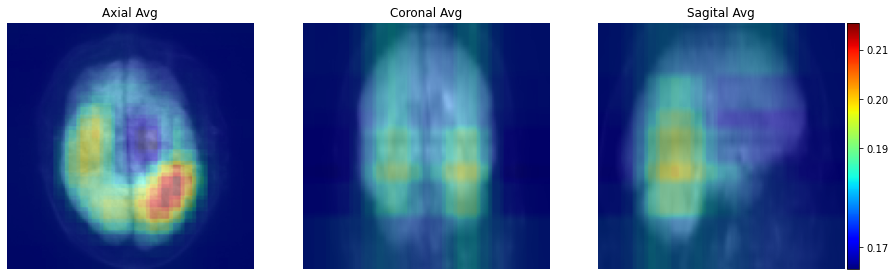

In [15]:
# occ_size = (16, 16, 12)
# occ_stride = 8
occ_size = (14, 14, 10)
occ_stride = 6
occlusion_interactive_plot(307,
                           occ_size = occ_size, occ_stride = occ_stride,
                           pred_hm_only=True)
